# Chapter 6

###  Understanding the LSTM and GRU layers

**SimpleRNN** isn’t the only recurrent layer available in **Tensorflow/Keras**. There are two others: 

* LSTM and 
* GRU. 

In practice, we’ll always use one of these, because `SimpleRNN` is generally too
simplistic to be of real use. `SimpleRNN` has a major issue: although it should theoretically
be able to retain at time `t` information about inputs seen many timesteps before, in
practice, such long-term dependencies are impossible to learn. 

This is due to the **vanishing gradient** problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as we keep adding layers
to a network, the network eventually becomes untrainable. 

**The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s**.

The **LSTM** and **GRU** layers are designed to solve this problem.

Let’s consider the `LSTM` layer. The underlying **Long Short-Term Memory (LSTM)** algorithm was developed by Hochreiter and Schmidhuber in 1997; it was the culmination of their research on the vanishing gradient problem. This layer is a variant of the `SimpleRNN` layer we already know about; it adds a way to carry information across **many timesteps**. 

Imagine a conveyor belt running parallel to the sequence we’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when we need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.
 
To understand this in detail, let’s start from the **SimpleRNN** cell.

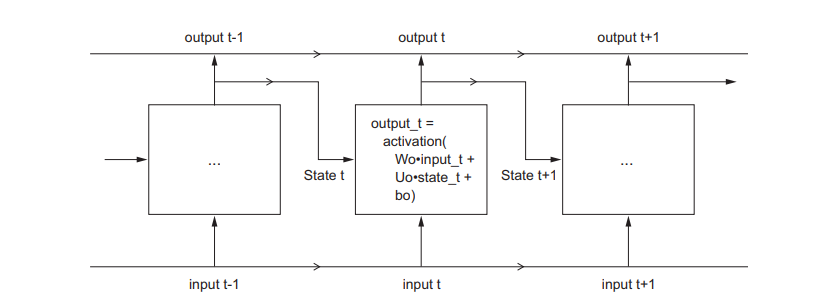

Because we’ll have a lot of weight matrices, index the `W` and `U` matrices in the cell with
the letter `o (Wo and Uo)` for output.

Let’s add to this picture an additional data flow that carries information across timesteps. Call its values at different timesteps `Ct`, where `C` stands for **carry**. This information will have the following impact on the cell: 
* It will be combined with the input
connection and the recurrent connection (via a dense transformation: **a dot product
with a weight matrix followed by a bias add and the application of an activation function**), and it will affect the state being sent to the next timestep (via an activation
function an a multiplication operation). Conceptually, the carry dataflow is a way to
modulate the next output and the next state. 

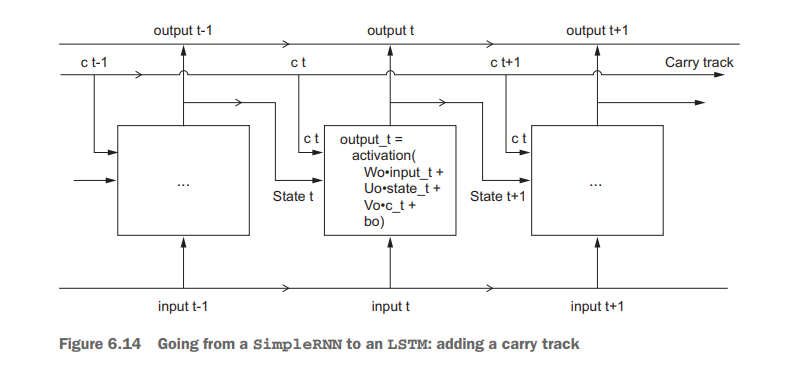

Now the subtlety: the way the next value of the carry dataflow is computed. It involves
three distinct transformations. All three have the form of a `SimpleRNN` cell:

`y = activation(dot(state_t, U) + dot(input_t, W) + b)`

But all three transformations have their own weight matrices, which we’ll index with
the letters `i`, `f`, and `k`. Here’s what we have so far (it may seem a bit arbitrary, but bear
with us).

`# Pseudocode details of the LSTM architecture (1/2)`

`output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)
 i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
 f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
 k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)`

We obtain the new carry state (the next `c_t`) by combining `i_t`, `f_t`, and `k_t`.

`# Pseudocode details of the LSTM architecture (2/2)`

`c_t+1 = i_t * k_t + c_t * f_t`

Add this as shown in figure below. And that’s it.

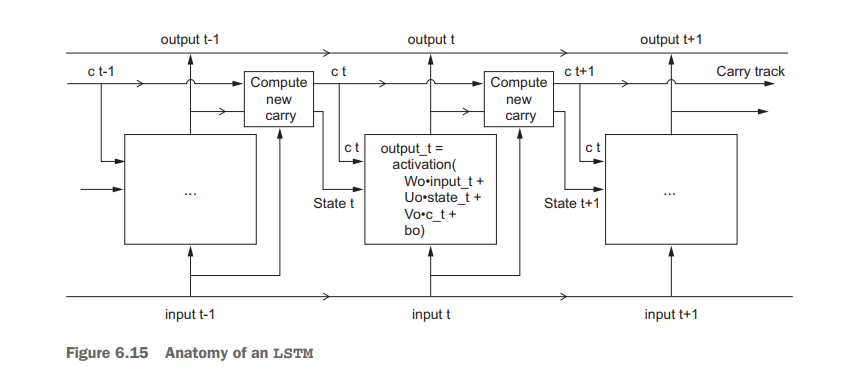

If we want to get philosophical, we can interpret what each of these operations is
meant to do. For instance, we can say that;
* Multiplying `c_t` and `f_t` is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, 
* `i_t` and `k_t` provide information about the present, updating the carry track with new information.

But at the end of the day, these interpretations don’t mean much, because what these
operations actually do is determined by the contents of the weights parameterizing
them; and the weights are learned in an end-to-end fashion, starting over with each
training round, making it impossible to credit this or that operation with a specific
purpose. 

The specification of an **RNN cell** (as just described) determines our **hypothesis space—the space in which we’ll search for a good model configuration during
training**—but it doesn’t determine what the cell does; that is up to the cell weights.

The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints
on our search, not as a design in an engineering sense.
 
 To a researcher, it seems that the choice of such constraints—the question of how to
implement **RNN cells**—is better left to optimization algorithms (like genetic algorithms
or reinforcement learning processes) than to human engineers. And in the future,
that’s how we’ll build networks. 

**In summary**: We don’t need to understand anything
about the specific architecture of an **LSTM cell**; as a human, it shouldn’t be our job to
understand it. Just keep in mind what the **LSTM cell** is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

### A concrete LSTM example in Keras

Now let’s switch to more practical concerns: we’ll set up a model using an **LSTM layer**
and train it on the IMDB data. The network is similar to the one with `SimpleRNN`. We only specify the output dimensionality of the **LSTM layer**; leave every other argument (there are many) at the **Tensorflow/Keras** defaults. 

**Tensorflow/Keras** has good defaults, and things will almost always **just work** without
having to spend time tuning parameters by hand.

In [5]:
max_features = 10000
maxlen = 500
batch_size = 32

In [7]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [11]:
print('Loading data...')

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [12]:
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [13]:
# Using the LSTM layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [14]:
history = model.fit(input_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 78s 451ms/step - loss: 0.6084 - acc: 0.6613 - val_loss: 0.3250 - val_acc: 0.8726
Epoch 2/10
157/157 [==============================] - 66s 421ms/step - loss: 0.3114 - acc: 0.8773 - val_loss: 0.3216 - val_acc: 0.8716
Epoch 3/10
157/157 [==============================] - 67s 430ms/step - loss: 0.2311 - acc: 0.9136 - val_loss: 0.3449 - val_acc: 0.8466
Epoch 4/10
157/157 [==============================] - 67s 429ms/step - loss: 0.1968 - acc: 0.9280 - val_loss: 0.2956 - val_acc: 0.8762
Epoch 5/10
157/157 [==============================] - 69s 437ms/step - loss: 0.1662 - acc: 0.9406 - val_loss: 0.3314 - val_acc: 0.8692
Epoch 6/10
157/157 [==============================] - 69s 442ms/step - loss: 0.1519 - acc: 0.9458 - val_loss: 0.3016 - val_acc: 0.8828
Epoch 7/10
157/157 [==============================] - 83s 532ms/step - loss: 0.1329 - acc: 0.9528 - val_loss: 0.4554 - val_acc: 0.8628
Epoch 8/10
157/157 [==============================] - 9

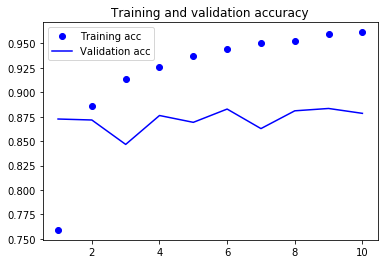

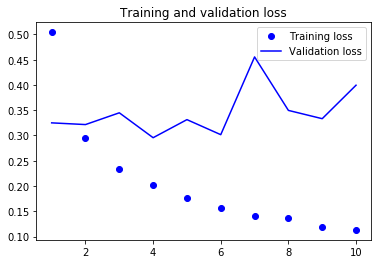

In [15]:
#  Plotting results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This time, we achieve up to `89%` validation accuracy. Not bad: certainly much better
than the `SimpleRNN` network—that’s largely because `LSTM` suffers much less from the
vanishing-gradient problem—and slightly better than the fully connected approach
from chapter 3, even though we’re looking at less data than we were in chapter 3. We’re truncating sequences after 500 timesteps, whereas in chapter 3, we were considering full sequences.
 
 
But this result isn’t groundbreaking for such a computationally intensive
approach. Why isn’t `LSTM` performing better? 

* One reason is that we made no effort to tune hyperparameters such as the 
    * embeddings dimensionality or 
    * the LSTM output dimensionality. 
* Another may be lack of regularization. 

But honestly, the primary reason is that, analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the
first fully connected approach looked at.

But there are far more difficult natural language-processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.

### Conclusion

Now we understand the following:
* What RNNs are and how they work
* What LSTM is, and why it works better on long sequences than a naive RNN
* How to use **Tensorflow/Keras** RNN layers to process sequence data

Next, we’ll review a number of more advanced features of RNNs, which can help us
get the most out of our deep-learning sequence models.